<a href="https://colab.research.google.com/github/esfandiaryfard/machine-learning/blob/main/Medical_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The code is based on Temporal Gan, the repository and the related paper is here:

https://github.com/Zasder3/Tganv2-PyTorch-Train-Sparsely--Generate-Densely.git

In [ ]:
!pip install scikit-video
!pip install monai
from google.colab import drive
drive = drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.4 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import torch.nn.functional as F
import math
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from skvideo import io
from tqdm.gui import tqdm
import torch.nn.utils as utils

In [ ]:
batchsize = 8

Data Loader


/usr/local/lib/python3.8/dist-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)
Loading dataset: 100%|██████████| 118/118 [00:00<00:00, 239442.61it/s]


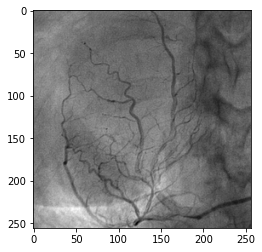

In [ ]:
import sys
import os
import json
from torch.utils.data import DataLoader
from monai.data import CacheDataset, DataLoader
from monai.transforms import (
    Compose,
    MapTransform,
    AddChannelD,
    RepeatChannelD,
    LoadImageD,
    ScaleIntensityD,
    NormalizeIntensityD,
    RandFlipD,
    RandRotate90D,
    ResizeD,
    ResizeWithPadOrCropD,
    ToTensorD)
from monai.config import KeysCollection
import copy
import argparse

class AppendRootDirD(MapTransform):
    def __init__(self, keys: KeysCollection, root_dir):
        super().__init__(keys)
        self.root_dir = root_dir
    
    def __call__(self, data):
        d = copy.deepcopy(data)
        for k in self.keys:
            d[k] = os.path.join(self.root_dir,d[k])
        return d

class FFRDataset3D(CacheDataset):
    def __init__(self, root_dir, split_path, transforms, cache_num = sys.maxsize, cache_rate=1.0, num_workers=1):    
        if not os.path.isdir(root_dir):
            raise ValueError("Root directory root_dir must be a directory.")
        
        with open(split_path) as fp:
           data=json.load(fp)

        transforms_comp = Compose([
            AppendRootDirD('image', root_dir),
            transforms,
            ])
        super().__init__(data, transforms_comp, cache_num=cache_num, cache_rate=cache_rate, num_workers=num_workers)

def get_loader(args):
    transforms = Compose([
        LoadImageD(['image']),
        AddChannelD(['image']),
        ResizeD(['image'], spatial_size = args.resize),
        ScaleIntensityD(['image']),
        NormalizeIntensityD(
            ['image'], 
            subtrahend=args.mean, 
            divisor=args.std, 
            channel_wise=True
            ),
        ResizeWithPadOrCropD(['image'], spatial_size=args.pad, method="end"),
        ToTensorD(['image']),
        RandFlipD(['image'], prob = 0.5, spatial_axis=1),
        RandFlipD(['image'], prob = 0.5, spatial_axis=2),
        RandRotate90D(['image'], prob = 0.5, spatial_axes=(1,2))
        ])

    dataset = FFRDataset3D(
        root_dir = args.root_dir, 
        split_path = args.split_path, 
        transforms = transforms
        )
    
    loader = DataLoader(dataset,
                        batch_size = args.batch_size,
                        num_workers=0,
                        shuffle=args.shuffle)

    return loader

import matplotlib.pyplot as plt
if __name__ == '__main__':
    args={}
    args['resize'] = (-1,256,256) # dataset max 256x256
    args['pad'] = (50,256,256)
    args['mean'] = (0.5173,)
    args['std'] = (0.1908,)
    args['root_dir'] = os.path.join('drive/MyDrive/dataset/')
    args['split_path'] = os.path.join('drive/MyDrive/dataset/dataset.json')
    args['batch_size'] = batchsize
    args['shuffle'] = True
    args = argparse.Namespace(**args)

    # Dataset e Loader
    loader = get_loader(args)

    # Get samples
    tmp = next(iter(loader))
    plt.imshow(tmp['image'][1].numpy()[:,49,:,:].transpose(1,2,0).squeeze(), cmap="gray") 
    plt.show()

In [ ]:
tmp['image'].mean()

tensor(-0.1176)

In [ ]:
tmp['image'].std()

tensor(0.8424)

In [ ]:
tmp['image'][1].numpy()[:,20,:,:].transpose(1,2,0).squeeze().shape

(256, 256)

Generator Cells

In [ ]:
class CLSTM_cell(nn.Module):
    def __init__(self, n_filters):
        """Convolutional LSTM Cell

        Args:
            n_filters (int): Number of LSTM channels
        """
        super(CLSTM_cell, self).__init__()
        self.w_x = nn.Conv2d(n_filters, n_filters * 4, kernel_size=3,
                             padding=1)
        self.w_h = nn.Conv2d(n_filters, n_filters * 4, kernel_size=3,
                             padding=1, bias=False)

    def forward(self, x, h=None, c=None):
        xifoc = self.w_x(x)
        xi, xf, xo, xc = xifoc.chunk(4, dim=1)
        if h is not None:
            hi, hf, ho, hc = self.w_h(h).chunk(4, dim=1)
        else:
            hi, hf, ho, hc = torch.zeros_like(xifoc).chunk(4, dim=1)

        if c is None:
            c = torch.zeros_like(x)

        ci = torch.sigmoid(xi + hi)
        cf = torch.sigmoid(xf + hf)
        co = torch.sigmoid(xo + ho)
        cc = cf * c + ci * torch.tanh(xc + hc)
        ch = torch.tanh(cc) * co

        return ch, cc


class CLSTM(nn.Module):
    def __init__(self, n_filters, n_frames):
        """Full Convolutional LSTM

        Args:
            n_filters (int): Number of LSTM channels
            n_frames (int): Frames to generate
        """
        super(CLSTM, self).__init__()
        self.cell = CLSTM_cell(n_filters)
        self.n_frames = n_frames

    def forward(self, z):
        # Assume z is in proper convolutional shape
        out = torch.stack([torch.zeros_like(z)]*self.n_frames, dim=1)

        h, c = None, None
        for i in range(self.n_frames):
            h, c = self.cell(z, h, c)
            out[:, i] = h
            z = torch.zeros_like(z)

        return out


class Up(nn.Module):
    def __init__(self, cin, cout):
        """Upscale and convolutions in ResNet setup

        Args:
            cin (int): in channels
            cout (int): out channels
        """
        super(Up, self).__init__()
        self.relu = nn.ReLU()

        # define main branch
        self.upsample = nn.Upsample(scale_factor=2)
        self.bn1 = nn.BatchNorm2d(cin)
        self.convm1 = nn.Conv2d(cin, cout, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(cout)
        self.convm2 = nn.Conv2d(cout, cout, kernel_size=3, padding=1)

        # define skip branch
        self.sconv = nn.Conv2d(cin, cout, kernel_size=1)

        # initialize
        nn.init.xavier_uniform_(self.convm1.weight, gain=math.sqrt(2))
        nn.init.xavier_uniform_(self.convm2.weight, gain=math.sqrt(2))
        nn.init.xavier_uniform_(self.sconv.weight)

    def forward(self, x):
        # compute main
        h = self.bn1(x)
        h = self.relu(h)
        h = self.upsample(h)
        h = self.convm1(h)
        h = self.bn2(h)
        h = self.relu(h)
        h = self.convm2(h)

        # compute skip
        s = self.upsample(x)
        s = self.sconv(s)

        return h + s


class Render(nn.Module):
    def __init__(self, cin, colors=3):
        """Render an image given the parameters

        Args:
            cin (int): in channels
            colors (int, optional): Color channels. Defaults to 3.
        """
        super(Render, self).__init__()
        self.bn = nn.BatchNorm2d(cin)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(cin, colors, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv(x)
        x = torch.tanh(x)

        return x


class Generator_CLSTM(nn.Module):
    def __init__(self, z_dim=256,
                 tempc=1024,
                 zt_dim=3,
                 upchannels=[512, 256, 128],
                 subchannels=[64, 32, 32],
                 n_frames=16,
                 colors=3):
        """Full generator CLSTM model

        Args:
            z_dim (int, optional): Latent z. Defaults to 256.
            tempc (int, optional): CLSTM channels. Defaults to 1024.
            zt_dim (int, optional): CLSTM window size. Defaults to 3.
            upchannels (list, optional): Defaults to [512, 256, 128].
            subchannels (list, optional): Defaults to [64, 32, 32].
            n_frames (int, optional): Frames to generate. Defaults to 16.
            colors (int, optional): Number of colors. Defaults to 3.
        """
        super(Generator_CLSTM, self).__init__()
        assert len(subchannels) == 3
        self.tempc = tempc
        self.zt_dim = zt_dim
        self.colors = colors

        self.fc = nn.Linear(z_dim, zt_dim**2 * tempc)
        self.temp = CLSTM(tempc, n_frames)

        self.build = nn.Sequential()
        for i in range(len(upchannels)):
            if not i:
                self.build.add_module('Up1', Up(tempc, upchannels[0]))
            else:
                self.build.add_module(f'Up{i+1}', Up(upchannels[i-1],
                                      upchannels[i]))

        self.buildr = Render(upchannels[-1], colors=colors)

        self.sup1 = Up(upchannels[-1], subchannels[0])
        self.sup1r = Render(subchannels[0], colors=colors)
        self.sup2 = Up(subchannels[0], subchannels[1])
        self.sup2r = Render(subchannels[1], colors=colors)
        self.sup3 = Up(subchannels[1], subchannels[2])
        self.sup3r = Render(subchannels[2], colors=colors)

    def subsample(self, h, N, T, frames=4):
        # to vid
        _, C, H, W = h.shape
        h = h.view(N, T, C, H, W)
        h = h[:, np.random.randint(min(frames, T))::frames]
        N, T, C, H, W = h.shape
        # to train
        h = h.contiguous().view(N * T, C, H, W)
        return h, T

    def forward(self, z, test=False):
        """Compute generator forward pass

        Args:
            z (torch.Tensor): Latent z [batch_size, z_dim]
            test (bool, optional): Produce test videos. Defaults to False.

        Returns:
            list(torch.Tensor) or torch.Tensor: Subsampled or regular videos
        """
        h = self.fc(z)
        h = h.view(-1, self.tempc, self.zt_dim, self.zt_dim)
        h = self.temp(h)
        N, T, C, H, W = h.shape
        h = h.view(N*T, C, H, W)
        h = self.build(h)

        outsize = self.zt_dim * 2 ** (len(self.build) + 3)

        if test:
            h = self.sup1(h)
            h = self.sup2(h)
            h = self.sup3(h)
            h = self.sup3r(h).view(N, T, self.colors, outsize,
                                   outsize).transpose(1, 2)

            return h
        else:
            # render 1st
            x1 = self.buildr(h).view(N, T, self.colors, outsize // 8,
                                     outsize // 8)
            h, T = self.subsample(h, N, T)
            h = self.sup1(h)
            # render 2nd
            x2 = self.sup1r(h).view(N, T, self.colors, outsize // 4,
                                    outsize // 4)
            h, T = self.subsample(h, N, T)
            h = self.sup2(h)
            # render 3rd
            x3 = self.sup2r(h).view(N, T, self.colors, outsize // 2,
                                    outsize // 2)
            h, T = self.subsample(h, N, T)
            h = self.sup3(h)
            # render 4th
            x4 = self.sup3r(h).view(N, T, self.colors, outsize, outsize)

        return x1, x2, x3, x4

MiniBach Discriminator

Using L1 norm

L2 norm cause Vanishing Gradient

In [ ]:
class MiniBatchDiscrimination(nn.Module):
    def __init__(self, A, B, C, batch_size):
      super(MiniBatchDiscrimination, self).__init__()
      self.feat_num = A
      self.out_size = B
      self.row_size = C
      self.N = batch_size
      self.T = Parameter(torch.Tensor(A,B,C))
      self.reset_parameters()

    def forward(self, x):
      # Output matrices after matrix multiplication
      M = x.mm(self.T.view(self.feat_num,self.out_size*self.row_size)).view(-1,self.out_size,self.row_size)
      out = Variable(torch.zeros(self.N,self.out_size))
      for k in range(self.N): # Not happy about this 'for' loop, but this is the best we could do using PyTorch IMO
        c = torch.exp(-torch.sum(torch.abs(M[k,:]-M),2)) # exp(-L1 Norm of Rows difference)
        if k != 0 and k != self.N -1: 
          out[k,:] = torch.sum(c[0:k,:],0) + torch.sum(c[k:-1,:],0)
        else:
          if k == 0:
            out[k,:] = torch.sum(c[1:,:],0)
          else:
            out[k,:] = torch.sum(c[0:self.N-1],0)
      return out

    def reset_parameters(self):
      stddev = 1/self.feat_num
      self.T.data.uniform_(stddev)

Discriminator


In [ ]:
class OptimizedDiscBlock(nn.Module):
    def __init__(self, cin, cout):
        """Optimized Discriminator Block

        Args:
            cin (int): in channels
            cout (int): out channels
        """
        super(OptimizedDiscBlock, self).__init__()
        self.c1 = nn.Conv3d(cin, cout, kernel_size=3, padding=1)
        self.c2 = nn.Conv3d(cout, cout, kernel_size=3, padding=1)
        self.c_sc = nn.Conv3d(cin, cout, kernel_size=1, padding=0)
        self.relu = nn.ReLU()
        self.avgp2d = nn.AvgPool3d(kernel_size=(1, 2, 2))

        # init
        nn.init.xavier_uniform_(self.c1.weight, gain=math.sqrt(2))
        nn.init.xavier_uniform_(self.c2.weight, gain=math.sqrt(2))
        nn.init.xavier_uniform_(self.c_sc.weight)

    def forward(self, x):
        h = self.c1(x)
        h = self.relu(h)
        h = self.c2(h)
        h = self.avgp2d(h)

        s = self.avgp2d(x)
        s = self.c_sc(s)

        return h + s


class DisBlock(nn.Module):
    def __init__(self, cin, cout):
        """Discriminator Block

        Args:
            cin (int): in channels
            cout (int): out channels
        """
        super(DisBlock, self).__init__()
        self.c1 = nn.Conv3d(cin, cin, kernel_size=3, padding=1)
        self.c2 = nn.Conv3d(cin, cout, kernel_size=3, padding=1)
        self.s_sc = nn.Conv3d(cin, cout, kernel_size=1, padding=0)
        self.relu = nn.ReLU()

        # init
        nn.init.xavier_uniform_(self.c1.weight, gain=math.sqrt(2))
        nn.init.xavier_uniform_(self.c2.weight, gain=math.sqrt(2))
        nn.init.xavier_uniform_(self.s_sc.weight)

    def downsample(self, x):
        ksize = [(2 if 1 < k else 1) for k in x.shape[2:]]
        pad = [(0 if k % 2 == 0 else 1) for k in x.shape[2:]][::-1]
        padf = []
        for p in pad:
            padf.append(p)
            padf.append(p)
        x = F.pad(x, padf)
        return F.avg_pool3d(x, kernel_size=ksize, padding=0)

    def forward(self, x):
        h = self.relu(x)
        h = self.c1(h)
        h = self.relu(h)
        h = self.c2(h)
        h = self.downsample(h)

        s = self.s_sc(x)
        s = self.downsample(s)
        return h + s


class DisResNet(nn.Module):
    def __init__(self, channels=[64, 128, 256, 512, 1024], colors=3):
        """Singular discriminator with multiple DisBlocks

        Args:
            channels (list, optional): Defaults to [64, 128, 256, 512, 1024].
            colors (int, optional): Color channels. Defaults to 3.
        """
        super(DisResNet, self).__init__()
        self.convs = nn.Sequential()
        self.colors = colors

        for i in range(len(channels)):
            if not i:
                self.convs.add_module(
                    'OptDisc',
                    OptimizedDiscBlock(colors, channels[0])
                )
            else:
                self.convs.add_module(
                    f'Down{i}',
                    DisBlock(channels[i-1], channels[i])
                )
        
        self.mbd = MiniBatchDiscrimination(channels[-1], 64, 64, batchsize)  # added MBD module here
        self.fc = nn.Linear(channels[-1] + 64, 1)  # modified input size of fc layer
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        if x.shape[2] == self.colors:
            x = x.transpose(1, 2)
        h = self.convs(x)
        h = torch.sum(h, dim=(2, 3, 4))
        mbd_out = self.mbd(h.view(-1, self.mbd.feat_num)).cuda() # added mbd
        h = torch.cat((h, mbd_out), dim=1)  # concatenate output of MBD module
        h = self.fc(h)
        return h


class DisMultiResNet(nn.Module):
    def __init__(self, layers=4, channels=[64, 128, 256, 512, 1024], colors=3):
        """Multiple Discriminators to run inference on

        Args:
            layers (int, optional): Discriminator Count. Defaults to 4.
            channels (list, optional): Defaults to [64, 128, 256, 512, 1024].
            colors (int, optional): Color channels. Defaults to 3.
        """
        super(DisMultiResNet, self).__init__()
        self.layers = layers
        self.res = nn.ModuleList(
            [DisResNet(channels, colors) for _ in range(layers)]
        )
        
    def forward(self, x):
        assert self.layers == len(x)
        out = [self.res[i](x[i]) for i in range(self.layers)]
        out = torch.cat(out, dim=0)
        return out

Training

<ipython-input-10-ff6b5b935578>:65: TqdmExperimentalWarning: GUI is experimental/alpha
  for epoch in tqdm(range(epochs)):


Epoch 0 Dis 10.548744201660156 Gen 0.815062940120697


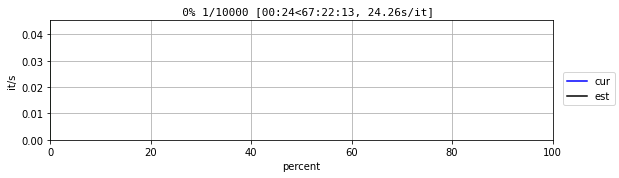

Epoch 1 Dis 14.361045837402344 Gen 0.8245082497596741
Epoch 2 Dis 14.263090133666992 Gen 0.7621515989303589
Epoch 3 Dis 79.29403686523438 Gen 0.7265027761459351
Epoch 4 Dis 3.744767665863037 Gen 0.768108606338501
Epoch 5 Dis 12.328317642211914 Gen 0.80235755443573
Epoch 6 Dis 3.0477869510650635 Gen 0.7293810248374939
Epoch 7 Dis 9.430532455444336 Gen 0.7119994163513184
Epoch 8 Dis 4.144028186798096 Gen 0.7461875081062317
Epoch 9 Dis 5.514387130737305 Gen 0.7355688810348511
Epoch 10 Dis 3.732396364212036 Gen 0.8459715843200684
Epoch 11 Dis 2.0186781883239746 Gen 0.7311465740203857
Epoch 12 Dis 34.19385528564453 Gen 0.8269966840744019
Epoch 13 Dis 17.61083221435547 Gen 0.7078850269317627
Epoch 14 Dis 22.750587463378906 Gen 0.8120037317276001
Epoch 15 Dis 4.189136028289795 Gen 0.7122988700866699
Epoch 16 Dis 0.5530110597610474 Gen 0.7026916146278381
Epoch 17 Dis 2.4050846099853516 Gen 0.7815990447998047
Epoch 18 Dis 6.852323532104492 Gen 0.6530067920684814
Epoch 19 Dis 19.050920486450195 

In [ ]:
def genSamples(g, n=8, e=1):
    with torch.no_grad():
        s = g(torch.rand((n**2, 256), device='cuda')*2-1,
              test=True).cpu().detach().numpy()
    out = np.zeros((1, 20, 64*n, 64*n))

    for j in range(n):
        for k in range(n):
            out[:, :, 64*j:64*(j+1), 64*k:64*(k+1)] = s[j*n + k, 0, :, :, :]

    out = out.transpose((1, 2, 3, 0))
    out = (np.concatenate([out, out, out], axis=3)+1) / 2 * 255
    io.vwrite(f'drive/MyDrive/medical_results/gensamples_id{e}.gif', out)


def subsample_real(h, frames=4):
    h = h[:, np.random.randint(min(frames, h.shape[1]))::frames]
    return h


def full_subsample_real(h, frames=4):
    out = []
    for i in range(4):
        if i:
            out.append(subsample_real(out[i-1], frames=frames))
        else:
            out.append(h)
    for i in range(4):
        for j in range(3-i):
            out[i] = F.avg_pool3d(out[i], kernel_size=(1, 2, 2))
    return out


def zero_centered_gp(real_data, pr):
    gradients = torch.autograd.grad(outputs=pr, inputs=real_data,
                                    grad_outputs=torch.ones_like(pr),
                                    create_graph=True, retain_graph=True)

    return sum([torch.sum(torch.square(g)) for g in gradients])


def train():
    epochs = 3000
    batch_size = batchsize
    lambda_val = 0.5

    # gen model
    dis = DisMultiResNet(channels=[32,64, 128, 256], colors=1).cuda()
    gen = Generator_CLSTM(
        tempc=256,
        zt_dim=4,
        upchannels=[128],
        subchannels=[64, 32, 32],
        n_frames=20,
        colors=1
    ).cuda()

    disOpt = torch.optim.Adam(dis.parameters(), lr=5e-5, betas=(0, 0.9))
    genOpt = torch.optim.Adam(gen.parameters(), lr=1e-4, betas=(0, 0.9))

    # train
    # note on loss function: within the current github repo they
    # employ softplus linear loss, if the normal cross entropy
    # is desired one may simply change the comments
    for epoch in tqdm(range(epochs)):
        # discriminator
        disOpt.zero_grad()
        real = next(iter(loader))
        real = real['image'].transpose(1,2)
        real = real.cuda()
        real = real.to(dtype=torch.float32) / 255 * 2 - 1
        real = full_subsample_real(real)
        for i in real:
            i.requires_grad = True
        pr = dis(real)
        dis_loss = zero_centered_gp(real, pr) * lambda_val
        # For the first 100 epochs just generator is working
        if epoch > 100:
          with torch.no_grad():
              fake = gen(torch.rand((batch_size, 256), device='cuda')*2-1)
          pf = dis(fake)
          dis_loss += torch.mean(F.softplus(-pr)) + torch.mean(F.softplus(pf))
          
          dis_loss.backward() 
          disOpt.step()

        # generator
        genOpt.zero_grad()
        fake = gen(torch.rand((batch_size, 256), device='cuda')*2-1)
        pf = dis(fake)
        gen_loss = torch.mean(F.softplus(-pf))
        gen_loss.backward()
        genOpt.step()

        # log results
        print('Epoch', epoch, 'Dis', dis_loss.item(), 'Gen', gen_loss.item())
        if epoch % 100 == 0:
            genSamples(gen, e=epoch)


if __name__ == '__main__':
    train()

The results are saved here:

https://drive.google.com/drive/folders/1eBO2ZCwU69oIZL6CbVmtSbWnfdCsgjdB?usp=sharing